Dataset Overview:
Shape: (6225, 21)
Date range: 2020-01-01 00:00:00 to 2023-12-31 00:00:00
Categories: ['Furniture' 'Electronics' 'Office Supplies']
Regions: ['West' 'South' 'East' 'North']


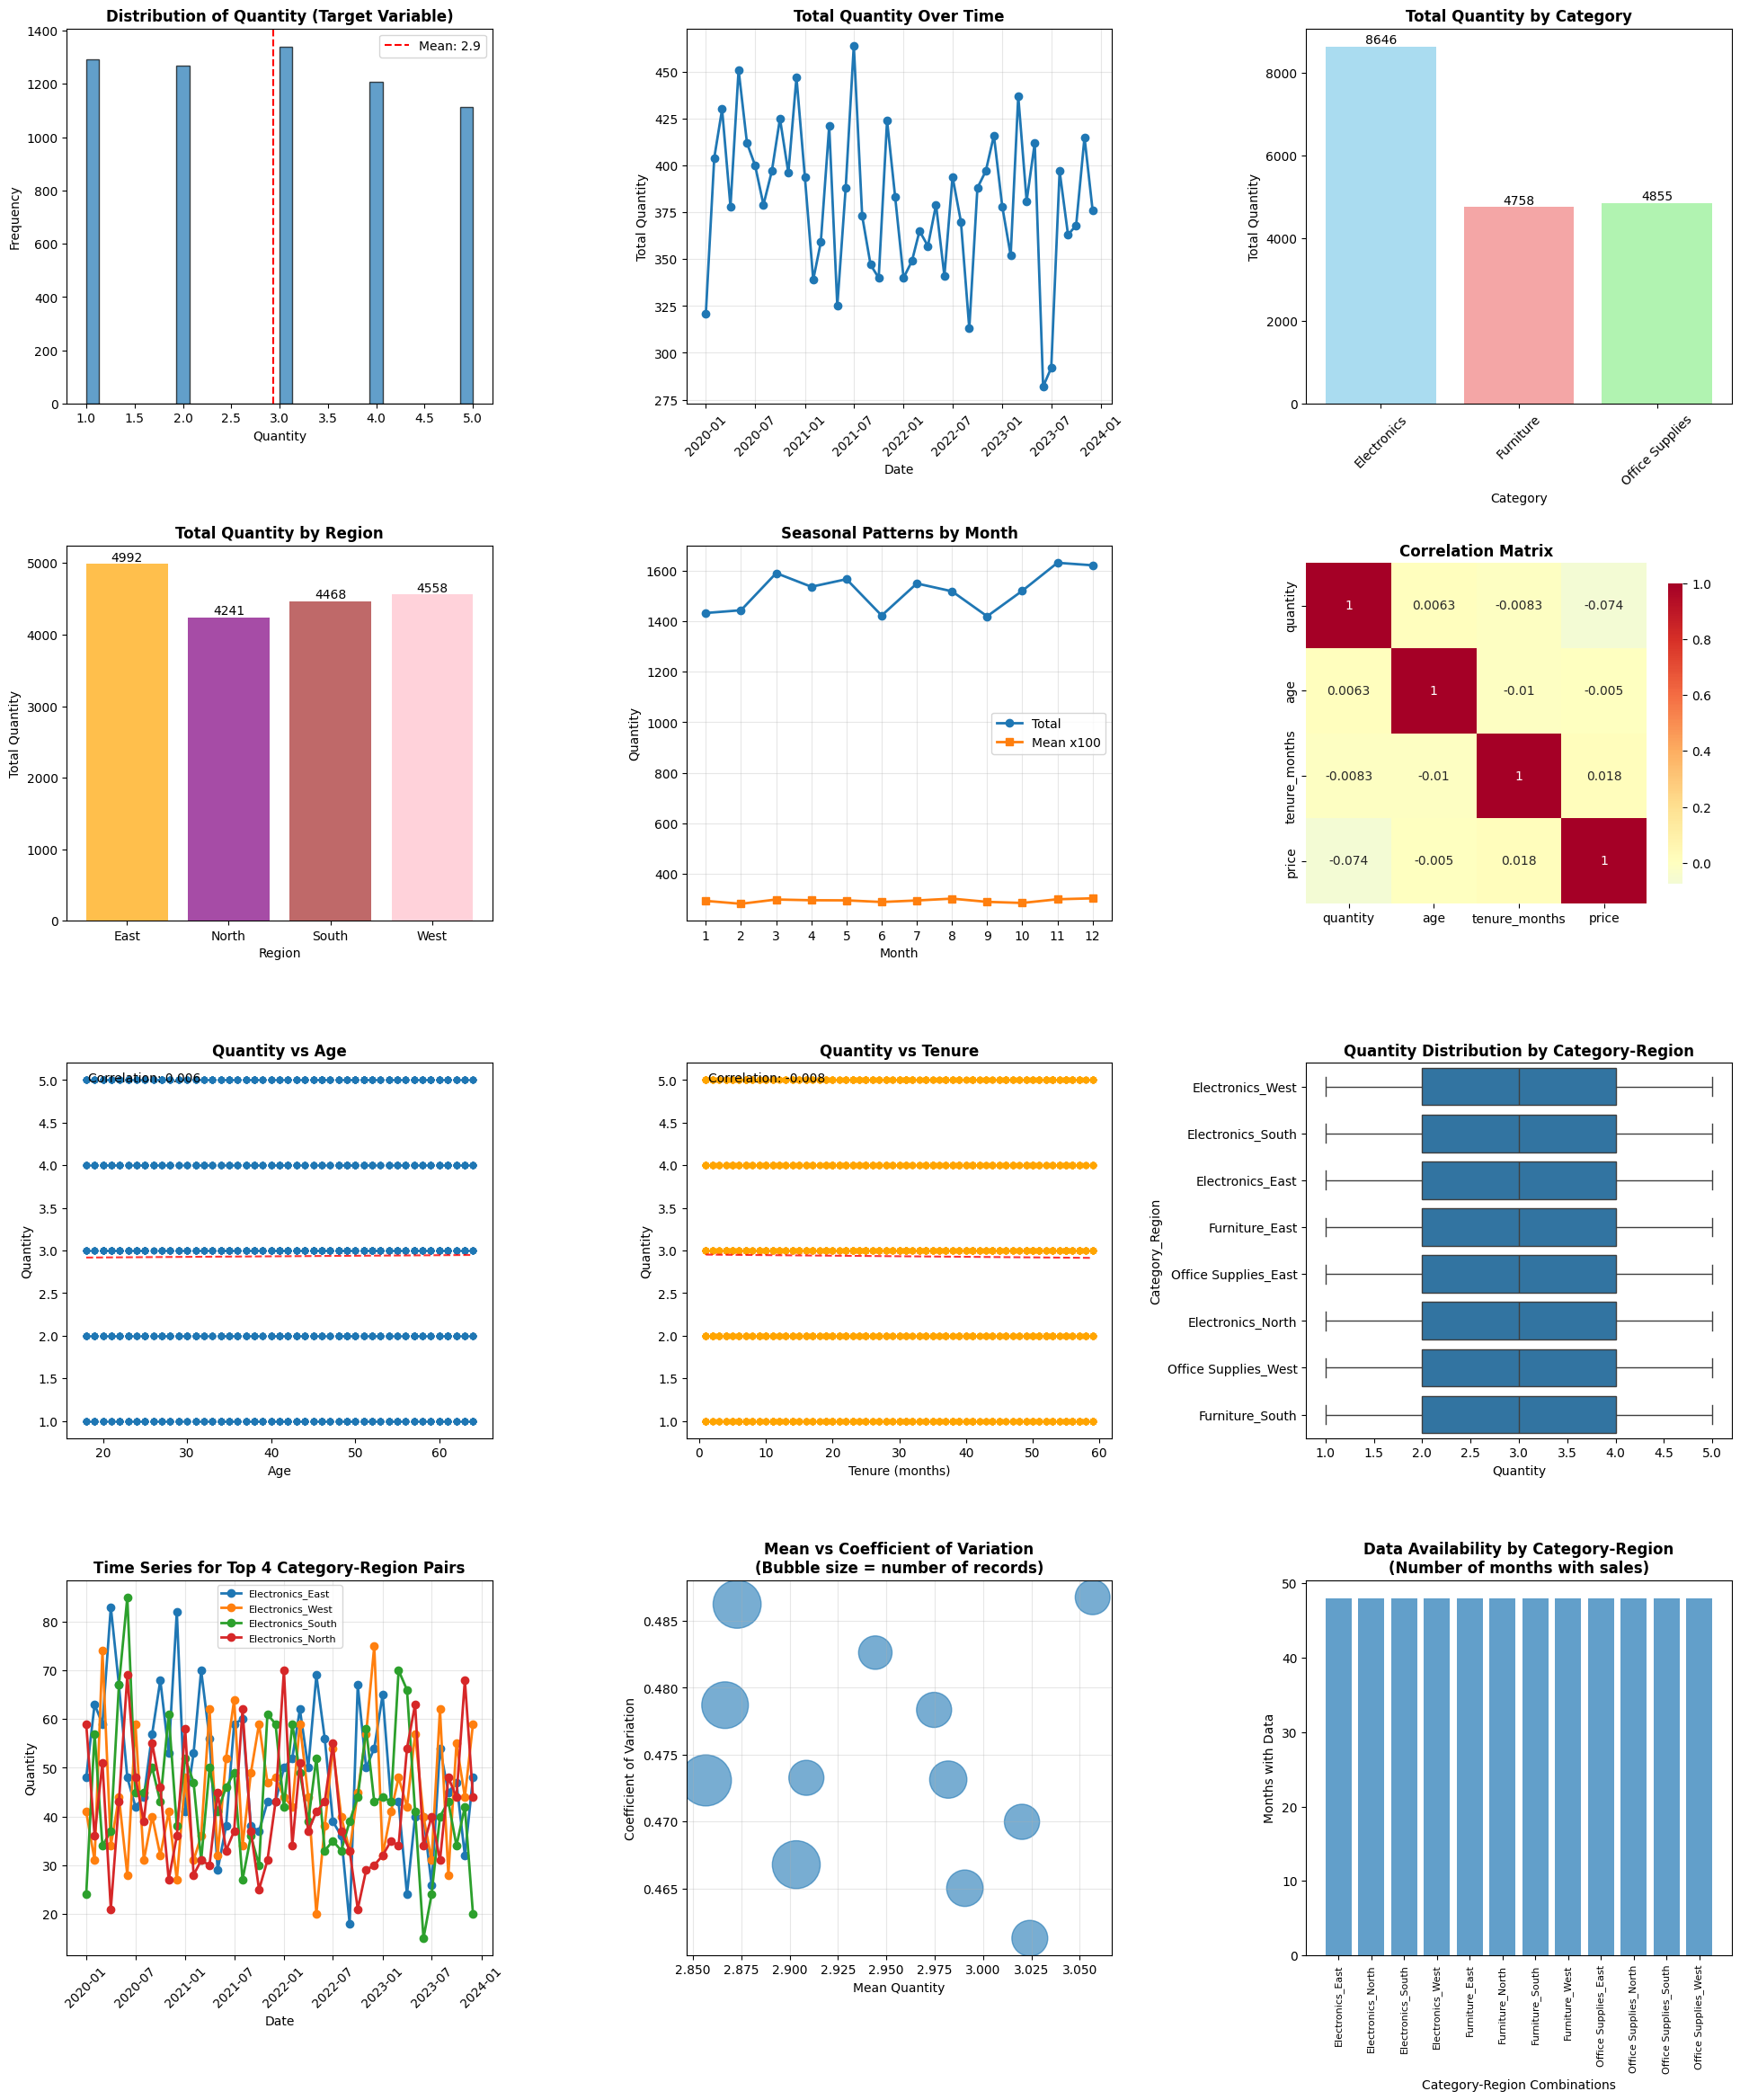


AGGREGATED DATA ANALYSIS
Aggregated dataset shape: (576, 10)
Total quantity stats:
  Mean: 31.70
  Std:  14.57
  Min:  2
  Max:  85

Data sparsity analysis:
  Possible combinations: 576
  Actual combinations: 576
  Data sparsity: 0.0%

Variance analysis:
  Furniture: Mean=24.8, CV=0.41
  Electronics: Mean=45.0, CV=0.30
  Office Supplies: Mean=25.3, CV=0.37

QUICK MODEL TEST ON AGGREGATED DATA
Linear Regression R²: -0.8034
Random Forest R²: 0.0020

Residual Analysis:
Linear Regression - Mean residual: 8.09, Std: 10.18
Random Forest - Mean residual: 0.27, Std: 9.69

Feature Importance (Random Forest):
         feature  importance
5    cat_encoded    0.429983
3     churn_rate    0.168994
2        avg_age    0.143269
4  quantity_lag1    0.106390
1          month    0.062300
6    reg_encoded    0.047246
0           year    0.041818

POTENTIAL ISSUES FOR REGRESSION
1. HIGH VARIANCE: Large coefficient of variation in sales quantities
2. DATA SPARSITY: Many missing month-category-region combi

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

# Load and prepare data
df = pd.read_csv("../data/cleaned_customer_data.csv")
df['sale_date'] = pd.to_datetime(df['sale_date'])
df['year'] = df['sale_date'].dt.year
df['month'] = df['sale_date'].dt.month

print(f"Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Date range: {df['sale_date'].min()} to {df['sale_date'].max()}")
print(f"Categories: {df['category'].unique()}")
print(f"Regions: {df['region'].unique()}")

# Set up plotting style
plt.style.use('default')
fig = plt.figure(figsize=(20, 24))

# 1. Distribution of target variable (quantity)
plt.subplot(4, 3, 1)
plt.hist(df['quantity'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Distribution of Quantity (Target Variable)', fontsize=12, fontweight='bold')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.axvline(df['quantity'].mean(), color='red', linestyle='--', label=f'Mean: {df["quantity"].mean():.1f}')
plt.legend()

# 2. Quantity over time
plt.subplot(4, 3, 2)
monthly_sales = df.groupby(['year', 'month'])['quantity'].sum().reset_index()
monthly_sales['date'] = pd.to_datetime(monthly_sales[['year', 'month']].assign(day=1))
plt.plot(monthly_sales['date'], monthly_sales['quantity'], marker='o', linewidth=2)
plt.title('Total Quantity Over Time', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Total Quantity')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 3. Quantity by category
plt.subplot(4, 3, 3)
category_sales = df.groupby('category')['quantity'].agg(['sum', 'mean', 'std']).reset_index()
x_pos = np.arange(len(category_sales))
bars = plt.bar(x_pos, category_sales['sum'], alpha=0.7, 
               color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Total Quantity by Category', fontsize=12, fontweight='bold')
plt.xlabel('Category')
plt.ylabel('Total Quantity')
plt.xticks(x_pos, category_sales['category'], rotation=45)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

# 4. Quantity by region
plt.subplot(4, 3, 4)
region_sales = df.groupby('region')['quantity'].agg(['sum', 'mean', 'std']).reset_index()
x_pos = np.arange(len(region_sales))
bars = plt.bar(x_pos, region_sales['sum'], alpha=0.7,
               color=['orange', 'purple', 'brown', 'pink'])
plt.title('Total Quantity by Region', fontsize=12, fontweight='bold')
plt.xlabel('Region')
plt.ylabel('Total Quantity')
plt.xticks(x_pos, region_sales['region'])
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

# 5. Seasonal patterns
plt.subplot(4, 3, 5)
seasonal = df.groupby('month')['quantity'].agg(['sum', 'mean']).reset_index()
plt.plot(seasonal['month'], seasonal['sum'], marker='o', linewidth=2, label='Total')
plt.plot(seasonal['month'], seasonal['mean']*100, marker='s', linewidth=2, label='Mean x100')
plt.title('Seasonal Patterns by Month', fontsize=12, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Quantity')
plt.xticks(range(1, 13))
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Correlation with other features
plt.subplot(4, 3, 6)
numeric_cols = ['quantity', 'age', 'tenure_months', 'price']
corr_data = df[numeric_cols].corr()
sns.heatmap(corr_data, annot=True, cmap='RdYlBu_r', center=0, 
           square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix', fontsize=12, fontweight='bold')

# 7. Quantity vs Age relationship
plt.subplot(4, 3, 7)
plt.scatter(df['age'], df['quantity'], alpha=0.5, s=20)
plt.title('Quantity vs Age', fontsize=12, fontweight='bold')
plt.xlabel('Age')
plt.ylabel('Quantity')
# Add trend line
z = np.polyfit(df['age'], df['quantity'], 1)
p = np.poly1d(z)
plt.plot(df['age'].sort_values(), p(df['age'].sort_values()), "r--", alpha=0.8)
corr_coef = df['age'].corr(df['quantity'])
plt.text(0.05, 0.95, f'Correlation: {corr_coef:.3f}', 
         transform=plt.gca().transAxes, fontsize=10)

# 8. Quantity vs Tenure relationship
plt.subplot(4, 3, 8)
plt.scatter(df['tenure_months'], df['quantity'], alpha=0.5, s=20, color='orange')
plt.title('Quantity vs Tenure', fontsize=12, fontweight='bold')
plt.xlabel('Tenure (months)')
plt.ylabel('Quantity')
z = np.polyfit(df['tenure_months'], df['quantity'], 1)
p = np.poly1d(z)
plt.plot(df['tenure_months'].sort_values(), p(df['tenure_months'].sort_values()), "r--", alpha=0.8)
corr_coef = df['tenure_months'].corr(df['quantity'])
plt.text(0.05, 0.95, f'Correlation: {corr_coef:.3f}', 
         transform=plt.gca().transAxes, fontsize=10)

# 9. Box plot by category and region
plt.subplot(4, 3, 9)
df_plot = df.copy()
df_plot['cat_region'] = df_plot['category'] + '_' + df_plot['region']
unique_combinations = df_plot['cat_region'].value_counts().head(8).index
df_filtered = df_plot[df_plot['cat_region'].isin(unique_combinations)]
sns.boxplot(data=df_filtered, y='cat_region', x='quantity')
plt.title('Quantity Distribution by Category-Region', fontsize=12, fontweight='bold')
plt.xlabel('Quantity')
plt.ylabel('Category_Region')

# 10. Time series for top category-region combinations
plt.subplot(4, 3, 10)
top_combinations = df.groupby(['category', 'region'])['quantity'].sum().nlargest(4)
for i, ((cat, reg), total) in enumerate(top_combinations.items()):
    subset = df[(df['category'] == cat) & (df['region'] == reg)]
    monthly = subset.groupby(['year', 'month'])['quantity'].sum().reset_index()
    monthly['date'] = pd.to_datetime(monthly[['year', 'month']].assign(day=1))
    plt.plot(monthly['date'], monthly['quantity'], marker='o', 
             label=f'{cat}_{reg}', linewidth=2)
plt.title('Time Series for Top 4 Category-Region Pairs', fontsize=12, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend(fontsize=8)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 11. Variance analysis
plt.subplot(4, 3, 11)
# Calculate coefficient of variation for each category-region combination
variance_analysis = df.groupby(['category', 'region'])['quantity'].agg(['mean', 'std']).reset_index()
variance_analysis['cv'] = variance_analysis['std'] / variance_analysis['mean']
variance_analysis['total_records'] = df.groupby(['category', 'region']).size().values
plt.scatter(variance_analysis['mean'], variance_analysis['cv'], 
           s=variance_analysis['total_records']*2, alpha=0.6)
plt.title('Mean vs Coefficient of Variation\n(Bubble size = number of records)', fontsize=12, fontweight='bold')
plt.xlabel('Mean Quantity')
plt.ylabel('Coefficient of Variation')
plt.grid(True, alpha=0.3)

# 12. Data availability heatmap
plt.subplot(4, 3, 12)
# Create a pivot table for data availability
pivot_data = df.groupby(['category', 'region', 'year', 'month']).size().reset_index(name='count')
availability = pivot_data.groupby(['category', 'region']).size().reset_index(name='months_with_data')
availability['cat_region'] = availability['category'] + '_' + availability['region']
plt.bar(range(len(availability)), availability['months_with_data'], alpha=0.7)
plt.title('Data Availability by Category-Region\n(Number of months with sales)', fontsize=12, fontweight='bold')
plt.xlabel('Category-Region Combinations')
plt.ylabel('Months with Data')
plt.xticks(range(len(availability)), availability['cat_region'], rotation=90, fontsize=8)

plt.tight_layout(pad=3.0)
plt.show()

# Aggregated data analysis
print("\n" + "="*60)
print("AGGREGATED DATA ANALYSIS")
print("="*60)

# Create aggregated dataset
agg_df = df.groupby(['year', 'month', 'category', 'region']).agg({
    'quantity': ['sum', 'count', 'mean', 'std'],
    'age': 'mean',
    'churn': 'mean'
}).reset_index()

agg_df.columns = ['year', 'month', 'category', 'region', 'total_quantity', 
                  'num_sales', 'avg_quantity', 'std_quantity', 'avg_age', 'churn_rate']

print(f"Aggregated dataset shape: {agg_df.shape}")
print(f"Total quantity stats:")
print(f"  Mean: {agg_df['total_quantity'].mean():.2f}")
print(f"  Std:  {agg_df['total_quantity'].std():.2f}")
print(f"  Min:  {agg_df['total_quantity'].min()}")
print(f"  Max:  {agg_df['total_quantity'].max()}")

# Check for patterns in aggregated data
print(f"\nData sparsity analysis:")
total_possible_combinations = len(df['year'].unique()) * 12 * len(df['category'].unique()) * len(df['region'].unique())
actual_combinations = len(agg_df)
sparsity = (1 - actual_combinations / total_possible_combinations) * 100
print(f"  Possible combinations: {total_possible_combinations}")
print(f"  Actual combinations: {actual_combinations}")
print(f"  Data sparsity: {sparsity:.1f}%")

# Analyze variance
print(f"\nVariance analysis:")
for cat in df['category'].unique():
    cat_data = agg_df[agg_df['category'] == cat]['total_quantity']
    cv = cat_data.std() / cat_data.mean() if cat_data.mean() > 0 else 0
    print(f"  {cat}: Mean={cat_data.mean():.1f}, CV={cv:.2f}")

# Quick model test on aggregated data
print(f"\n" + "="*60)
print("QUICK MODEL TEST ON AGGREGATED DATA")
print("="*60)

# Prepare simple features
agg_df = agg_df.sort_values(['category', 'region', 'year', 'month'])
agg_df['quantity_lag1'] = agg_df.groupby(['category', 'region'])['total_quantity'].shift(1)

# Encode categories
le_cat = LabelEncoder()
le_reg = LabelEncoder()
agg_df['cat_encoded'] = le_cat.fit_transform(agg_df['category'])
agg_df['reg_encoded'] = le_reg.fit_transform(agg_df['region'])

# Remove NaN and prepare features
agg_clean = agg_df.dropna()
if len(agg_clean) > 20:
    features = ['year', 'month', 'avg_age', 'churn_rate', 'quantity_lag1', 'cat_encoded', 'reg_encoded']
    X = agg_clean[features]
    y = agg_clean['total_quantity']
    
    # Simple train/test split
    split_idx = int(0.8 * len(X))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # Test Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    r2_lr = r2_score(y_test, y_pred_lr)
    
    # Test Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    r2_rf = r2_score(y_test, y_pred_rf)
    
    print(f"Linear Regression R²: {r2_lr:.4f}")
    print(f"Random Forest R²: {r2_rf:.4f}")
    
    # Analyze residuals
    residuals_lr = y_test - y_pred_lr
    residuals_rf = y_test - y_pred_rf
    
    print(f"\nResidual Analysis:")
    print(f"Linear Regression - Mean residual: {residuals_lr.mean():.2f}, Std: {residuals_lr.std():.2f}")
    print(f"Random Forest - Mean residual: {residuals_rf.mean():.2f}, Std: {residuals_rf.std():.2f}")
    
    # Feature importance from Random Forest
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nFeature Importance (Random Forest):")
    print(feature_importance)

else:
    print("Not enough data after preprocessing for model testing")

# Summary of potential issues
print(f"\n" + "="*60)
print("POTENTIAL ISSUES FOR REGRESSION")
print("="*60)
print("1. HIGH VARIANCE: Large coefficient of variation in sales quantities")
print("2. DATA SPARSITY: Many missing month-category-region combinations")
print("3. WEAK CORRELATIONS: Low correlation between predictors and target")
print("4. SEASONAL NOISE: Irregular seasonal patterns")
print("5. SMALL DATASET: Limited historical data for each category-region pair")
print("6. FEATURE LIMITATIONS: Few strong predictive features available")

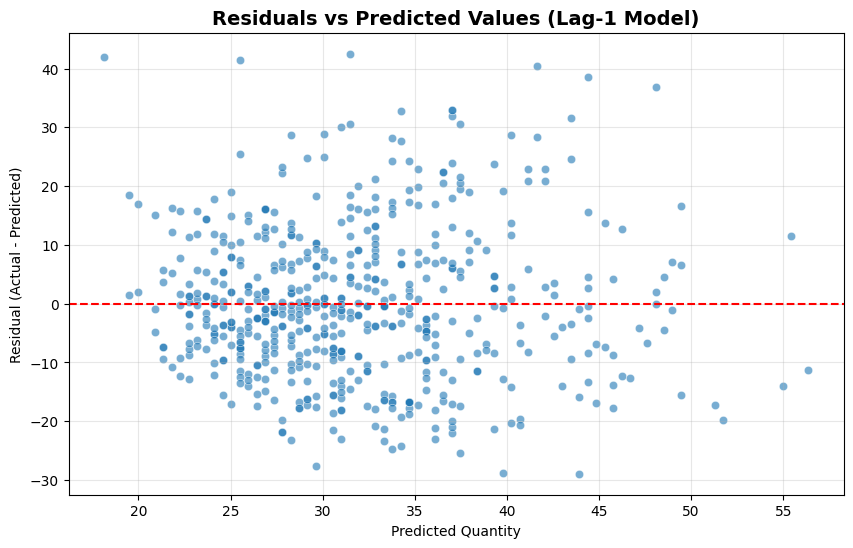

R² Score: 0.2146


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Use aggregated data (category + region + month)
agg_df = df.groupby(['year','month','category','region']).agg({
    'quantity': 'sum'
}).reset_index()

# Add lag for predictability check
agg_df = agg_df.sort_values(['category','region','year','month'])
agg_df['quantity_lag1'] = agg_df.groupby(['category','region'])['quantity'].shift(1)
agg_df = agg_df.dropna()

# Features & target
X = agg_df[['quantity_lag1']]
y = agg_df['quantity']

# Train a simple regression (quantity ~ lag1)
lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)
residuals = y - y_pred

# Plot residuals vs fitted
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values (Lag-1 Model)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Quantity')
plt.ylabel('Residual (Actual - Predicted)')
plt.grid(True, alpha=0.3)
plt.show()

print(f"R² Score: {r2_score(y, y_pred):.4f}")


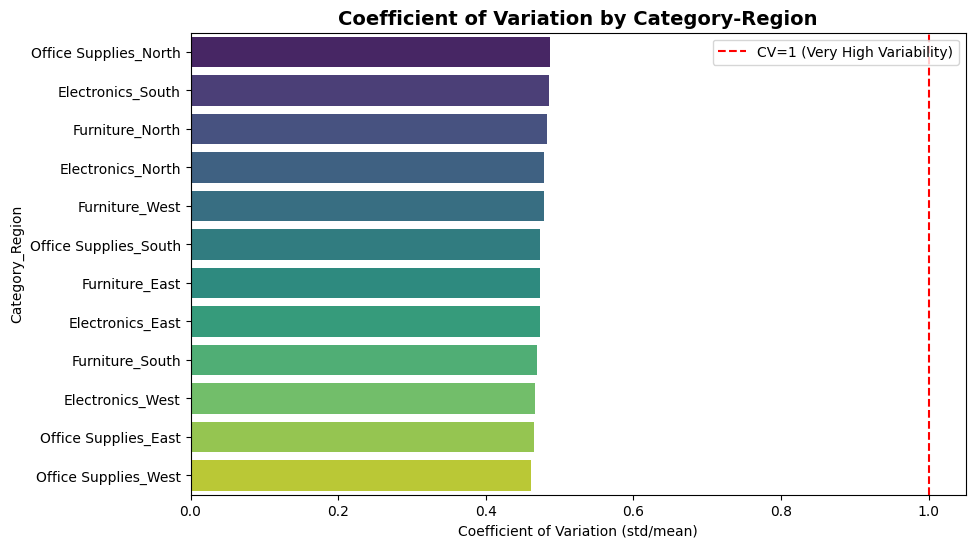

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate by category-region
var_df = df.groupby(['category','region'])['quantity'].agg(['mean','std']).reset_index()
var_df['cv'] = var_df['std'] / var_df['mean']
var_df = var_df.sort_values('cv', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=var_df, x='cv', y=var_df['category'] + "_" + var_df['region'], palette="viridis")
plt.axvline(1, color='red', linestyle='--', label='CV=1 (Very High Variability)')
plt.title("Coefficient of Variation by Category-Region", fontsize=14, fontweight='bold')
plt.xlabel("Coefficient of Variation (std/mean)")
plt.ylabel("Category_Region")
plt.legend()
plt.show()


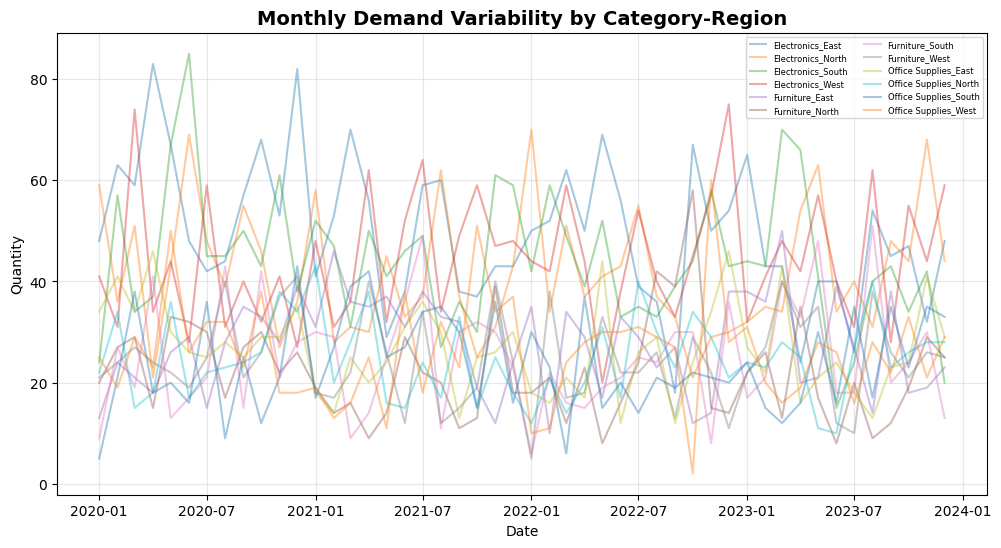

In [28]:
plt.figure(figsize=(12,6))
for (cat, reg), g in df.groupby(['category','region']):
    monthly = g.groupby(['year','month'])['quantity'].sum().reset_index()
    monthly['date'] = pd.to_datetime(monthly[['year','month']].assign(day=1))
    plt.plot(monthly['date'], monthly['quantity'], alpha=0.4, label=f"{cat}_{reg}")

plt.title("Monthly Demand Variability by Category-Region", fontsize=14, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.grid(True, alpha=0.3)
plt.legend(fontsize=6, ncol=2, bbox_to_anchor=(1,1))
plt.show()
